## Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import pyplot, transforms
from matplotlib.patches import Rectangle
import seaborn as sns
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
parent_dir = Path.cwd().parent.parent.parent

"""
This code is used for Fig4.C-D.accessibility and equity across U.S. regions segmented by GDP. 
"""

'\nThis code is used for Fig4.C-D.accessibility and equity across U.S. regions segmented by GDP. \n'

## Data Processing

GDP data：https://www.arcgis.com/home/item.html?id=e091ee8a53bb46bda86c88342f7bee43

In [2]:
def load_and_merge_us_map_data(geojson_path, parent_directory=None):
    """
    Load and merge US map geospatial data with political party information.
    """
    # Read US map GeoJSON file and select relevant columns
    gdf1 = gpd.read_file(geojson_path)
    gdf1 = gdf1[['GID_0', 'GID_1', 'GID_2', 'COUNTRY', 'NAME_1', 'NAME_2', 'geometry']]
    
    # Read political party data from Excel file
    geojson_path = 'US_GDP_Total.geojson'
    data_gdp = gpd.read_file(geojson_path)
    data_gdp = data_gdp[~data_gdp['GDP from All Industries (Total)'].isna()]
    
    # Merge geospatial data with party information using GID_1 as the key
    # GID_1 typically represents state-level identifiers
    usa_map_gdf = pd.merge(
        gdf1, 
        data_gdp[['GID_2','GDP from All Industries (Total)']], 
        left_on='GID_2', 
        right_on='GID_2', 
        how='left'
    )
    
    return usa_map_gdf, data_gdp

In [3]:
def processing_acc_data(year, usa_map_gdf, parent_dir, type='population-based'):
    """
    Process EV charging station accessibility data for a given year.
    """
    # Load EV charging station data for specified year
    if type == 'population-based':
        acc_file = parent_dir / 'data' / 'US-accessibility' / 'population-based' / f'{year}' / f'{year}_city_accessibility_summaries_evse_count.csv'
    elif type == 'facility-based':
        acc_file = parent_dir / 'data' / 'US-accessibility' / 'facility-based' / f'{year}_poi_1km' / f'{year}_accessibility_summary_evse_num.csv'
    
    evse_data = pd.read_csv(acc_file)
    # Merge accessibility data with US map geometries using GID_2 identifier
    merged_gdf = pd.merge(
        usa_map_gdf, 
        evse_data[['GID_2', 'Average_Accessibility']], 
        on='GID_2', 
        how='left'
    )
    merged_gdf = merged_gdf.fillna(0)

    return merged_gdf

In [4]:
def combine_accessibility_data(matched_gdf_2014, matched_gdf_2019, matched_gdf_2024):
    """
    Combine accessibility data from multiple years and calculate growth rates by political party.
    """
    
    # Combine DataFrames from three years and add Year identifier
    combined_df = pd.concat([
        matched_gdf_2014.assign(Year=2014),
        matched_gdf_2019.assign(Year=2019), 
        matched_gdf_2024.assign(Year=2024)
    ])
    
    # Reshape data from long to wide format - accessibility values as columns by year
    merged_df = combined_df.pivot(
        index='GID_2',          # Unique geographical identifier
        columns='Year',         # Year becomes column headers  
        values='Average_Accessibility'  # Accessibility values populate cells
    ).reset_index()
    
    # Rename columns for clarity
    merged_df.columns = ['GID_2', 'Accessibility_2014', 'Accessibility_2019', 'Accessibility_2024']
    
    # Merge political party information (assumed constant across years)
    party_info = matched_gdf_2014[['GID_2', 'Region_HT']]
    merged_df = pd.merge(merged_df, party_info, on='GID_2')

    # Calculate percentage growth rate from 2014 to 2019
    # Handle division by zero by replacing with NaN, then fill with 0
    merged_df['Growth1'] = np.where(
        merged_df['Accessibility_2014'] != 0,
        ((merged_df['Accessibility_2019'] - merged_df['Accessibility_2014']) / merged_df['Accessibility_2014']) * 100,
        np.nan
    )

    # Calculate percentage growth rate from 2019 to 2024
    merged_df['Growth2'] = np.where(
        merged_df['Accessibility_2019'] != 0,
        ((merged_df['Accessibility_2024'] - merged_df['Accessibility_2019']) / merged_df['Accessibility_2019']) * 100,
        np.nan
    )
    
    # Replace NaN values with 0 for analysis
    merged_df = merged_df.fillna(0)
    
    # Calculate median growth rates grouped by political party
    median_growth_2014_2019 = merged_df.groupby('Region_HT')['Growth1'].median()
    median_growth_2019_2024 = merged_df.groupby('Region_HT')['Growth2'].median()
    
    return median_growth_2014_2019, median_growth_2019_2024

In [5]:
"""
Head/Tail Break (suitable for heavy-tailed distributions such as power-law distributions)
If the GDP data follows a power-law distribution (where a few counties contribute most of the GDP), the Head/Tail Break method can be used. It recursively divides the data by the median until the classification requirements are met.

Steps:

Calculate the median of the entire dataset and divide the data into "Head" (above the median) and "Tail" (below the median).

Recursively divide the Head portion until the desired number of classes is reached (here, 3 classes are needed, so the process is repeated twice).

Final Classification:

Class 1 (High GDP): First Head (top 50%)

Class 2 (Medium GDP): Second Head (top 50% of the first Head, i.e., top 25%)

Class 3 (Low GDP): Remaining portion (bottom 75%)
"""



def classify_gdp_regions(data_gdp, gdp_column='GDP from All Industries (Total)', plot_results=True):
    """
    Classify regions into High, Medium, and Low GDP categories based on median breaks.
    """
    
    # Sort GDP values in descending order and reset index
    sorted_gdp = data_gdp[gdp_column].sort_values(ascending=False).reset_index(drop=True)
    
    # Plot sorted GDP distribution if requested
    if plot_results:
        plt.figure(figsize=(6, 3))
        plt.plot(sorted_gdp, 'b-', linewidth=2)
        plt.xlabel('Rank', fontsize=12)
        plt.ylabel(gdp_column, fontsize=12)
        plt.title('GDP by Rank (Descending Order)', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Calculate breakpoints using median values
    # First breakpoint: median of all GDP values
    #data_gdp = data_gdp[gdp_column].dropna()
    break_1 = data_gdp[gdp_column].median()
    print(break_1)
    
    # Second breakpoint: median of GDP values above the first breakpoint
    break_2 = (data_gdp[data_gdp[gdp_column] > break_1][gdp_column]).median()
    
    print(f"First breakpoint (median): {break_1}")
    print(f"Second breakpoint (median of values above first breakpoint): {break_2}")
    
    # Classify regions into three categories based on GDP values
    data_gdp['Region_HT'] = np.select(
        [
            data_gdp[gdp_column] > break_2,                           # High GDP
            (data_gdp[gdp_column] <= break_2) & 
            (data_gdp[gdp_column] > break_1),                         # Medium GDP
            data_gdp[gdp_column] <= break_1                           # Low GDP
        ],
        ["High GDP", "Medium GDP", "Low GDP"],
        default="Unknown"  # Handle any unmatched cases
    )
    
    # Print classification results
    classification_counts = data_gdp['Region_HT'].value_counts()
    print("\nClassification Results:")
    print(classification_counts)
    
    # Prepare statistics dictionary
    stats = {
        'break_1': break_1,
        'break_2': break_2,
        'classification_counts': classification_counts.to_dict(),
        'total_regions': len(data_gdp)
    }
    
    return data_gdp, stats

## Mapping and Visualization

In [6]:
def merge_geometries_by_attribute(gdf, groupby_column='NAME_1', crs=4326):
    """
    Merge geometries in a GeoDataFrame by grouping them based on a specified attribute column.
    """
    # Dictionary to store merged geometries
    merged_geometries = {}
    
    # Group by specified column and merge geometries for each group
    for name, group in gdf.groupby(groupby_column):
        if group['geometry'].size > 1:
            merged_geom = unary_union(group['geometry'].tolist())
        else:
            merged_geom = group['geometry'].iloc[0]
        merged_geometries[name] = merged_geom
    
    # Create new DataFrame to store merged results
    merged_df = pd.DataFrame.from_dict(merged_geometries, orient='index', columns=['geometry'])
    merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')
    
    # Add original grouping column as attribute column
    merged_gdf[groupby_column] = merged_gdf.index
    
    # Reset index to get clean sequential indexing
    merged_gdf.reset_index(drop=True, inplace=True)
    
    # Set Coordinate Reference System for the output GeoDataFrame
    merged_gdf_with_crs = merged_gdf.set_crs(epsg=crs)
    
    return merged_gdf_with_crs

In [7]:
def plot_gdp_regions_map(merged_gdf_with_crs, data_gdp, area='US', figsize=(10, 6), dpi=150):
    """
    Plot GDP regions map for specified area.
    """
    # Define CRS
    albers_proj = '+proj=aea +lat_1=20 +lat_2=60 +lon_0=0'
    
    # Define fonts
    font1 = {'family':'Arial', 'style':'italic', 'weight':'normal', 'color':'black', 'size':6}
    font2 = {'family':'Arial', 'weight':'normal', 'size':6}
    font3 = {'family':'fantasy', 'weight':'bold', 'color':'teal'}
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    plt.rcParams['legend.labelspacing'] = 0.8
    plt.rcParams['legend.title_fontsize'] = 8
    
    base = pyplot.gca().transData
    rot = transforms.Affine2D().rotate_deg(60)
    
    # Plot base map
    ax = merged_gdf_with_crs.to_crs(albers_proj).plot(
        ax=ax, aspect='equal', facecolor='none', edgecolor='black', 
        linewidth=0.2, alpha=0.5, zorder=11, transform=rot+base
    )
    
    # Plot GDP regions
    ax = data_gdp.to_crs(albers_proj).plot(
        ax=ax,
        column='Region_HT',
        cmap=ListedColormap(['skyblue', 'thistle', 'salmon']),
        categorical=True,
        missing_kwds={
            "color": "lightgray",
            "edgecolor": "white", 
            "hatch": "//",
            "label": "No Data"
        },
        edgecolor='lightgray',
        linewidth=0.15,
        legend_kwds={
            'loc': 'lower right',
            'title': 'GDP Region',
            'shadow': False,
            'prop': font2
        },
        zorder=2,
        transform=rot+base
    )
    
    # Set area bounds
    if area == 'US':
        ax.set_ylim(-3600000, 0)
        ax.set_xlim(-12800000, -7300000)
    elif area == 'AK':
        ax.set_ylim(450000, 3000000)
        ax.set_xlim(-15800000, -12000000)
    elif area == 'HI':
        ax.set_ylim(-2500000, -1000000)
        ax.set_xlim(-17000000, -15500000)
    
    ax.axis('off')
    
    return fig, ax

In [8]:
def plot_growth_with_arrows_and_boxplot(growth_data, combined_df, figsize=(8, 4), ylim=(-5, 160), ylim2=(-5, 2000),ylabel_name = r'$\bf{Pop.-based\ Acc.}$'):
    """
    Plot Region_HT growth rate comparison with arrows and boxplot
    """
    combined_df = combined_df.reset_index(drop=True)
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Define Region_HT background colors (RGBA format, transparency 0.1)
    Region_HT_bg_colors = {
        'Low GDP': (1.0, 0.4, 0.4, 0.1),    # Light red background
        'High GDP': (0.4, 0.4, 1.0, 0.1),    # Light blue background
        'Medium GDP': (0.8, 0.4, 1.0, 0.1)    # Light purple background
    }
    
    # ===== First Subplot: Growth Rate with Arrows =====
    growth_df = pd.DataFrame(growth_data)
    
    # Draw background colors for each Region_HT
    for i, Region_HT in enumerate(['Low GDP', 'Medium GDP', 'High GDP']):
        x_start = i - 0.5
        x_end = i + 0.5
        ax1.add_patch(Rectangle(
            (x_start, ylim[0]), width=x_end-x_start, height=ylim[1]-ylim[0],
            facecolor=Region_HT_bg_colors[Region_HT], edgecolor='none', zorder=-1
        ))
    
    # Plot growth rate points (white circles)
    sns.stripplot(
        data=growth_df.melt(id_vars='Region_HT', var_name='Type', value_name='Rate'),
        x='Region_HT',
        y='Rate',
        order=['Low GDP', 'Medium GDP', 'High GDP'],
        palette={'Low GDP': 'white', 'Medium GDP': 'white', 'High GDP': 'white'},
        size=8,
        edgecolor='black',
        linewidth=1,
        jitter=False,
        ax=ax1
    )
    
    # Add arrows connecting the two growth rates
    for i,Region_HT in enumerate(['Low GDP', 'Medium GDP', 'High GDP']):
        rate1 = growth_df[growth_df['Region_HT'] == Region_HT]['Growth_Rate1'].values[0]
        rate2 = growth_df[growth_df['Region_HT'] == Region_HT]['Growth_Rate2'].values[0]
        
        # Draw arrow
        ax1.annotate(
            '', xy=(i, rate2), xytext=(i, rate1),
            arrowprops=dict(
                arrowstyle='->', 
                color='green', 
                lw=2,
                shrinkA=0, shrinkB=0
            ),
            zorder=10
        )
        
        # Add labels
        ax1.text(i+0.05, rate1, f'{rate1:.2f}%', ha='left', va='center', fontsize=11)
        ax1.text(i+0.05, rate2, f'{rate2:.2f}%', ha='left', va='center', fontsize=11)
    
    # Add dashed lines to separate parties
    ax1.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.axvline(x=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Set axis properties
    ax1.set_ylim(ylim[0], ylim[1])
    ax1.set_ylabel(r'$\bf{Growth\ (\%)}$', fontsize=15)
    ax1.set_xticklabels(['Low GDP', 'Medium GDP', 'High GDP'], fontsize=10)
    ax1.set_xlabel('')
    ax1.set_xticks([])  # Hide x-axis ticks
    
    # ===== Second Subplot: Boxplot =====
    # Draw background colors for each Region_HT
    for i, Region_HT in enumerate(['Low GDP', 'Medium GDP', 'High GDP']):
        x_start = i - 0.5
        x_end = i + 0.5
        ax2.add_patch(Rectangle(
            (x_start, -5),  # Bottom-left coordinates (x,y)
            width=x_end-x_start,  # Width
            height=ylim2[1]-ylim2[0],  # Height (covers y-axis range)
            facecolor=Region_HT_bg_colors[Region_HT],
            edgecolor='none',
            zorder=-1  # Ensure it's in the background
        ))
    
    # Plot boxplot
    sns.boxplot(
        data=combined_df,
        x='Region_HT',
        y='Average_Accessibility',
        hue='Year',
        palette={'2014': 'orangered', '2019': 'teal', '2024': 'dodgerblue'},
        width=0.5,
        dodge=True,
        gap=0.3,
        order=['Low GDP', 'Medium GDP', 'High GDP'],
        flierprops={
            'marker': 'o',
            'markerfacecolor': 'white',
            'markeredgecolor': 'white',
            'markersize': 1.5
        },
        medianprops={
            'color': 'Orange',
            'linewidth': 2,
            'linestyle': '--'
        },
        ax=ax2
    )
    
    # Add dashed lines to separate different parties
    ax2.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axvline(x=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Set y-axis range
    ax2.set_ylim(ylim2[0], ylim2[1])
    
    # Adjust label styles
    ax2.set_xlabel(r'$\bf{Counties\ by\ GDP}$', fontsize=15, labelpad=8)
    ax2.set_ylabel(ylabel_name, fontsize=15)
    ax2.set_xticklabels(
        ax2.get_xticklabels(),
        rotation=0,  # Rotation angle
        fontsize=10,  # Font size
        ha='center'   # Horizontal alignment
    )
    
    # Remove default legend
    ax2.legend_.remove()
    
    plt.tight_layout()
    return fig, (ax1, ax2)

## Test run

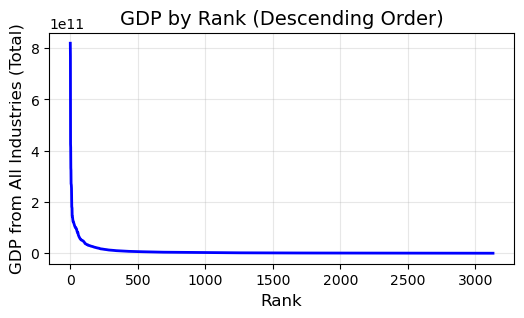

1088775500.0
First breakpoint (median): 1088775500.0
Second breakpoint (median of values above first breakpoint): 3236418500.0

Classification Results:
Region_HT
Low GDP       1566
Medium GDP     783
High GDP       783
Unknown         16
Name: count, dtype: int64


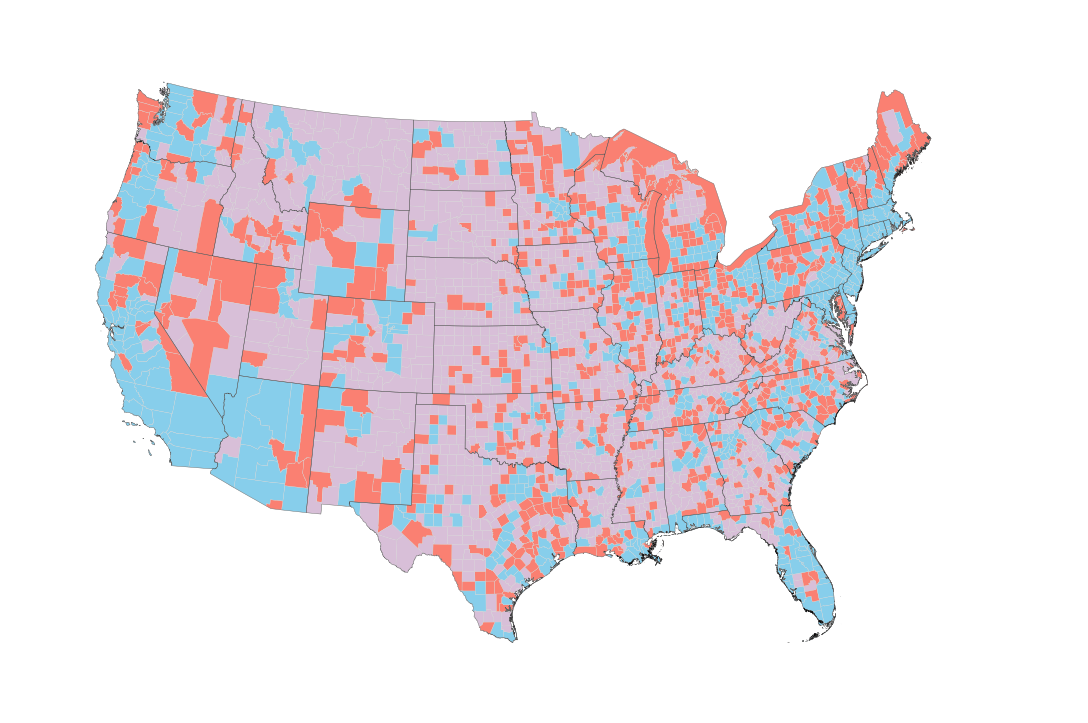

In [11]:
if __name__ == "__main__":

    # load data
    usa_map_gdf, _ = load_and_merge_us_map_data (parent_dir / 'data' / 'US-map'/ 'usa_map.geojson')
    merged_gdf = merge_geometries_by_attribute(usa_map_gdf, 'GID_1')

    # Classify GDP regions
    data_gdp_classified, classification_stats = classify_gdp_regions(usa_map_gdf)
    
     # Plot mainland US political map
    fig_us, ax_us = plot_gdp_regions_map(merged_gdf, data_gdp_classified, area='US')
    plt.show()
    
    # Plot Alaska political map
    #fig_ak, ax_ak = plot_gdp_regions_map(merged_gdf, usa_map_gdf, area='AK')
    #plt.show()
    
    # Plot Hawaii political map
    #fig_hi, ax_hi = plot_gdp_regions_map(merged_gdf, usa_map_gdf, area='HI')
    #plt.show()

## Test run - population-based acc.

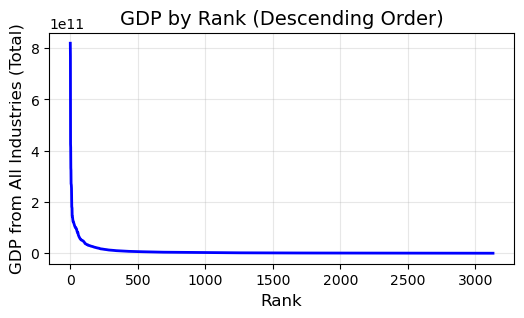

1088775500.0
First breakpoint (median): 1088775500.0
Second breakpoint (median of values above first breakpoint): 3236418500.0

Classification Results:
Region_HT
Low GDP       1566
Medium GDP     783
High GDP       783
Name: count, dtype: int64


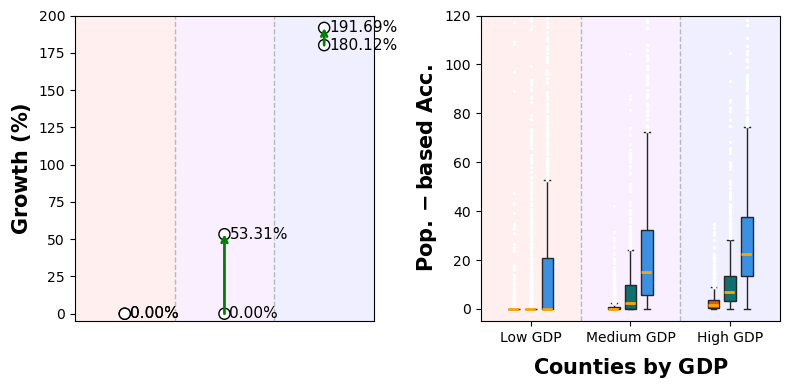

In [12]:
if __name__ == "__main__":
    # load data
    usa_map_gdf, data_gdp = load_and_merge_us_map_data (parent_dir / 'data' / 'US-map'/ 'usa_map.geojson')

    # Classify GDP regions
    data_gdp_classified, _ = classify_gdp_regions(data_gdp)

    # population-based
    pop_matched_gdf_2014 = processing_acc_data(2014, data_gdp_classified, parent_dir, type='population-based')
    pop_matched_gdf_2019 = processing_acc_data(2019, data_gdp_classified, parent_dir, type='population-based')
    pop_matched_gdf_2024 = processing_acc_data(2024, data_gdp_classified, parent_dir, type='population-based')
    
    pop_median_growth_2014_2019, pop_median_growth_2019_2024 = combine_accessibility_data(pop_matched_gdf_2014, pop_matched_gdf_2019, pop_matched_gdf_2024)
    
    pop_median_growth_2014_2019 = pop_median_growth_2014_2019.drop('Unknown', errors='ignore')
    pop_median_growth_2019_2024 = pop_median_growth_2019_2024.drop('Unknown', errors='ignore')

    desired_order = ['High GDP', 'Medium GDP', 'Low GDP']

    pop_median_growth_2014_2019 = pop_median_growth_2014_2019.reindex(desired_order)
    pop_median_growth_2019_2024 = pop_median_growth_2019_2024.reindex(desired_order)
    
    # Prepare growth data
    growth_data = {
        'Region_HT': ['Low GDP', 'Medium GDP', 'High GDP'],
        'Growth_Rate1': pop_median_growth_2014_2019.tolist()[::-1],  # Initial growth rate
        'Growth_Rate2': pop_median_growth_2019_2024.tolist()[::-1] # Final growth rate
    }

    # Prepare combined DataFrame (assuming you have the data)
    # Add Year column to each DataFrame
    pop_matched_gdf_2014['Year'] = '2014'
    pop_matched_gdf_2019['Year'] = '2019'
    pop_matched_gdf_2024['Year'] = '2024'
    
    # Merge DataFrames
    combined_df = pd.concat([pop_matched_gdf_2014, pop_matched_gdf_2019, pop_matched_gdf_2024])

    # Create the plot
    fig, (ax1, ax2) = plot_growth_with_arrows_and_boxplot(growth_data, combined_df,ylim=(-5, 200),ylim2=(-5, 120))
    plt.show()

## Test run - facility-based acc.

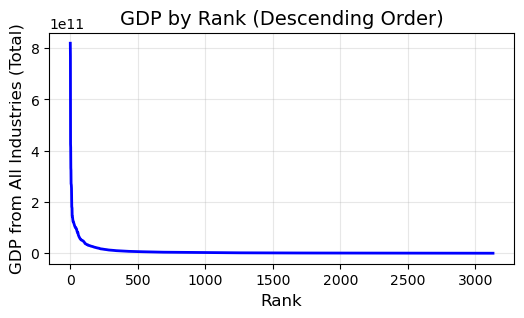

1088775500.0
First breakpoint (median): 1088775500.0
Second breakpoint (median of values above first breakpoint): 3236418500.0

Classification Results:
Region_HT
Low GDP       1566
Medium GDP     783
High GDP       783
Name: count, dtype: int64


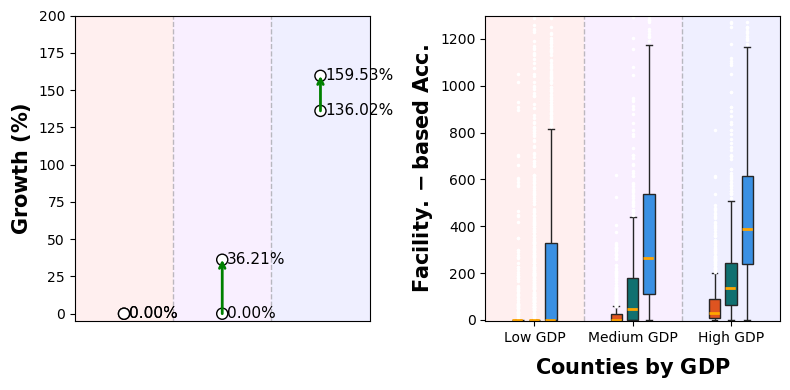

In [10]:
if __name__ == "__main__":
    # load data
    usa_map_gdf, data_gdp = load_and_merge_us_map_data (parent_dir / 'data' / 'US-map'/ 'usa_map.geojson')

    # Classify GDP regions
    data_gdp_classified, _ = classify_gdp_regions(data_gdp)

    # facility-based
    fac_matched_gdf_2014 = processing_acc_data(2014, data_gdp_classified, parent_dir, type='facility-based')
    fac_matched_gdf_2019 = processing_acc_data(2019, data_gdp_classified, parent_dir, type='facility-based')
    fac_matched_gdf_2024 = processing_acc_data(2024, data_gdp_classified, parent_dir, type='facility-based')
    
    fac_median_growth_2014_2019, fac_median_growth_2019_2024 = combine_accessibility_data(fac_matched_gdf_2014, fac_matched_gdf_2019, fac_matched_gdf_2024)
    
    fac_median_growth_2014_2019 = fac_median_growth_2014_2019.drop('Unknown', errors='ignore')
    fac_median_growth_2019_2024 = fac_median_growth_2019_2024.drop('Unknown', errors='ignore')

    desired_order = ['High GDP', 'Medium GDP', 'Low GDP']

    fac_median_growth_2014_2019 = fac_median_growth_2014_2019.reindex(desired_order)
    fac_median_growth_2019_2024 = fac_median_growth_2019_2024.reindex(desired_order)
    
    # Prepare growth data
    growth_data = {
        'Region_HT': ['Low GDP', 'Medium GDP', 'High GDP'],
        'Growth_Rate1': fac_median_growth_2014_2019.tolist()[::-1],  # Initial growth rate
        'Growth_Rate2': fac_median_growth_2019_2024.tolist()[::-1] # Final growth rate
    }

    # Prepare combined DataFrame (assuming you have the data)
    # Add Year column to each DataFrame
    fac_matched_gdf_2014['Year'] = '2014'
    fac_matched_gdf_2019['Year'] = '2019'
    fac_matched_gdf_2024['Year'] = '2024'
    
    # Merge DataFrames
    combined_df = pd.concat([fac_matched_gdf_2014, fac_matched_gdf_2019, fac_matched_gdf_2024])
   

    # Create the plot
    fig, (ax1, ax2) = plot_growth_with_arrows_and_boxplot(growth_data, combined_df,ylim=(-5, 200),ylim2=(-5, 1300),ylabel_name = r'$\bf{Facility.-based\ Acc.}$')
    plt.show()